<a href="https://colab.research.google.com/github/alankriti-dubey/DIC-Project/blob/main/DIC_Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Libraries

In [ ]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, expr, count, when, lit, initcap
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MultilabelClassificationEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Creating Spark Session

In [29]:

# Stop any active Spark session
active_session = SparkSession.getActiveSession()
if active_session is not None:
    active_session.stop()

# Create a new Spark session
spark = SparkSession.builder.appName("DiabetesPrediction").getOrCreate()


In [42]:
# Read data from CSV file into a DataFrame
df = spark.read.csv("diabetes_prediction_dataset.csv", header=True, inferSchema=True)

# Show the content of the DataFrame
df.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

## Data Preprocessing


### 1. Dropping Duplicate Rows

In [44]:
# Drop duplicate rows
df = df.dropDuplicates()

# Show the count of records after dropping duplicates
print(f"Number of records after dropping duplicates: {df.count()}")

Number of records after dropping duplicates: 96146


### 2. Converting Categorical Labels into a Numerical Format

In [43]:

# Convert categorical labels (e.g., 'gender') to numerical format
indexer = StringIndexer(inputCol="gender", outputCol="gender_indexed")
df = indexer.fit(df).transform(df)


indexer = StringIndexer(inputCol="smoking_history", outputCol="smoking_indexed")
df = indexer.fit(df).transform(df)

# Show the transformed DataFrame
print(df.select("smoking_indexed").distinct().collect())
df.select("gender_indexed").distinct().collect()


[Row(smoking_indexed=0.0), Row(smoking_indexed=1.0), Row(smoking_indexed=4.0), Row(smoking_indexed=3.0), Row(smoking_indexed=2.0), Row(smoking_indexed=5.0)]


[Row(gender_indexed=0.0), Row(gender_indexed=1.0), Row(gender_indexed=2.0)]

### 3. Handling Outliers for the 'age' Column

In [5]:

# Ensure 'age' contains only integer values
df = df.filter(col("age").cast("int").isNotNull())

# Show the count of records after filtering
print(f"Number of records after handling age outliers: {df.count()}")


Number of records after handling age outliers: 96146


### 4. Handling Outliers for the 'BMI' Column Using IQR

In [6]:

# Calculate Q1 and Q3
Q1 = df.approxQuantile("bmi", [0.25], 0.01)[0]
Q3 = df.approxQuantile("bmi", [0.75], 0.01)[0]
IQR = Q3 - Q1

# Calculate outlier boundaries
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filter rows that are within the acceptable range
df = df.filter((col("bmi") >= lower_limit) & (col("bmi") <= upper_limit))

# Show the filtered DataFrame
df.select("bmi").show(5)

+-----+
|  bmi|
+-----+
|27.32|
|27.32|
| 21.7|
|20.47|
| 31.4|
+-----+
only showing top 5 rows



### 5. Filtering Rows with Invalid Biological Values

In [7]:
df = df.filter((col("age") > 1) & (col("bmi") > 10) & (col("blood_glucose_level") >= 80))

# Show the filtered DataFrame
df.select("age", "bmi", "blood_glucose_level").show(5)

+----+-----+-------------------+
| age|  bmi|blood_glucose_level|
+----+-----+-------------------+
|21.0|27.32|                126|
|26.0|27.32|                100|
|49.0| 21.7|                158|
|24.0|20.47|                100|
|53.0| 31.4|                 85|
+----+-----+-------------------+
only showing top 5 rows



### 6. Checking for Inconsistent Data in Categorical Column

In [8]:

df = df.withColumn("smoking_history", initcap(col("smoking_history")))

# Show the transformed DataFrame
df.select("smoking_history").show(5)

+---------------+
|smoking_history|
+---------------+
|          Never|
|          Never|
|          Never|
|         Former|
|          Never|
+---------------+
only showing top 5 rows



### 7. Handling missing values

In [9]:


# Calculate the mode of 'smoking_history'
mode_value = df.groupBy("smoking_history").count().orderBy(col("count").desc()).first()[0]

# Replace 'No info' with the mode value
df = df.withColumn("smoking_history", when(col("smoking_history") == "No info", lit(mode_value)).otherwise(col("smoking_history")))

# Show the modified DataFrame
df.select("smoking_history").show(5)

+---------------+
|smoking_history|
+---------------+
|          Never|
|          Never|
|          Never|
|         Former|
|          Never|
+---------------+
only showing top 5 rows



### 8. Normalizing values

In [10]:

# Assemble columns into a vector
assembler = VectorAssembler(inputCols=["blood_glucose_level", "HbA1c_level"], outputCol="features")
df = assembler.transform(df)

# Apply StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Show the scaled features
df.select("scaled_features").show(5)

+--------------------+
|     scaled_features|
+--------------------+
|[-0.2904463527940...|
|[-0.9344938505553...|
|[0.50222749060444...|
|[-0.9344938505553...|
|[-1.3060597146483...|
+--------------------+
only showing top 5 rows



### 9. Dropping Null Values

In [11]:
# Drop rows with null values
df = df.na.drop()

# Show the count of records after dropping nulls
print(f"Number of records after dropping nulls: {df.count()}")

Number of records after dropping nulls: 89595


### 10. Feature Engineering

In [12]:

# Define BMI categories
df = df.withColumn("bmi_category",
                   when((col("bmi") > 0) & (col("bmi") <= 18.5), "Underweight")
                   .when((col("bmi") > 18.5) & (col("bmi") <= 24.9), "Normal")
                   .when((col("bmi") > 24.9) & (col("bmi") <= 29.9), "Overweight")
                   .when((col("bmi") > 29.9), "Obese"))

# Show the categorized BMI column
df.select("bmi", "bmi_category").show(5)

+-----+------------+
|  bmi|bmi_category|
+-----+------------+
|27.32|  Overweight|
|27.32|  Overweight|
| 21.7|      Normal|
|20.47|      Normal|
| 31.4|       Obese|
+-----+------------+
only showing top 5 rows



In [13]:
print(df)

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, smoking_history: string, bmi: double, HbA1c_level: double, blood_glucose_level: int, diabetes: int, gender_indexed: double, features: vector, scaled_features: vector, bmi_category: string]


## Algorithms/Visualizations

### Splitting the Dataset

In [45]:

# Assembling features
feature_cols = ["gender_indexed", "age", "hypertension", "heart_disease", "smoking_indexed", "bmi", "HbA1c_level", "blood_glucose_level"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

# Selecting final dataset
final_data = df.select(col("features"), col("diabetes").alias("label"))

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=1234)

### 1.Logistic Regression

In [46]:

# Initializing Logistic Regression model
logistic_reg = LogisticRegression(featuresCol="features", labelCol="label")

# Training the model
logistic_model = logistic_reg.fit(train_data)

# Evaluating on test data
predictions = logistic_model.transform(test_data)
predictions.select("features", "label", "prediction").show()


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(8,[1,5,6,7],[0.0...|    0|       0.0|
|(8,[1,5,6,7],[0.0...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



#### Evaluating Model Performance

#### Accuracy

In [52]:

# Evaluating accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9715354248909204


#### Confusion Matrix

In [53]:
# Confusion matrix
conf_matrix = predictions.groupBy("label", "prediction").count()
conf_matrix.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  548|
|    0|       0.0|17574|
|    1|       1.0| 1130|
+-----+----------+-----+



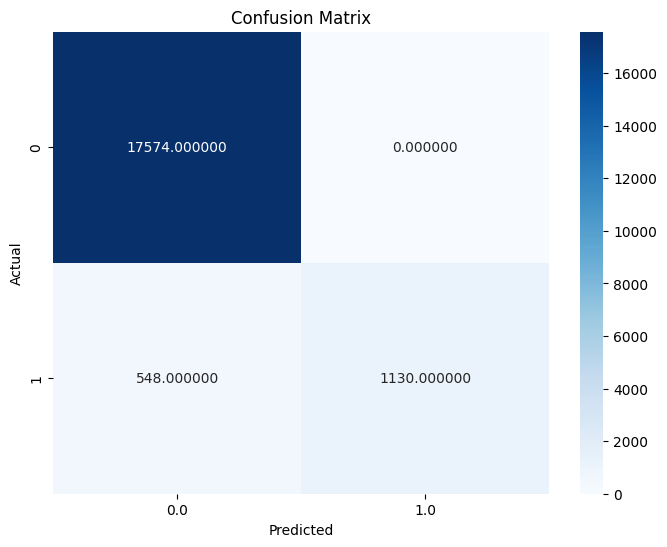

In [56]:


conf_matrix_pd = conf_matrix.toPandas().pivot(index='label', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pd, annot=True, fmt="f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [49]:

evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")


AUC: 0.943780466267415


In [55]:
roc_data = predictions.select("label", F.col("probability").getItem(1).alias("probability"))

roc_pd = roc_data.toPandas()
roc_pd['false_positive_rate'], roc_pd['true_positive_rate'] = zip(*roc_pd.apply(lambda row: (1-row.label, row.label), axis=1))

plt.figure(figsize=(8, 6))
plt.plot(roc_pd['false_positive_rate'], roc_pd['true_positive_rate'], marker='.')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

NameError: name 'F' is not defined

### 2. Decision Tree

In [47]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initializing Decision Tree model
decision_tree = DecisionTreeClassifier(featuresCol="features", labelCol="label")

# Training the model
dt_model = decision_tree.fit(train_data)

# Evaluating on test data
predictions = dt_model.transform(test_data)
predictions.select("features", "label", "prediction").show()


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(8,[1,5,6,7],[0.0...|    0|       0.0|
|(8,[1,5,6,7],[0.0...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



#### Evaluating Model Performance

In [50]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.9437804662674151


### 3. Random Forest

In [48]:
from pyspark.ml.classification import RandomForestClassifier

# Initializing Random Forest model
random_forest = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=10)

# Training the model
rf_model = random_forest.fit(train_data)

# Evaluating on test data
predictions = rf_model.transform(test_data)
predictions.select("features", "label", "prediction").show()


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(8,[1,5,6,7],[0.0...|    0|       0.0|
|(8,[1,5,6,7],[0.0...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.2...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.3...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
|(8,[1,5,6,7],[0.4...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



#### Evaluating Model Performance


In [51]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.9437804662674151
